### Generate the shear strength and moisture map.

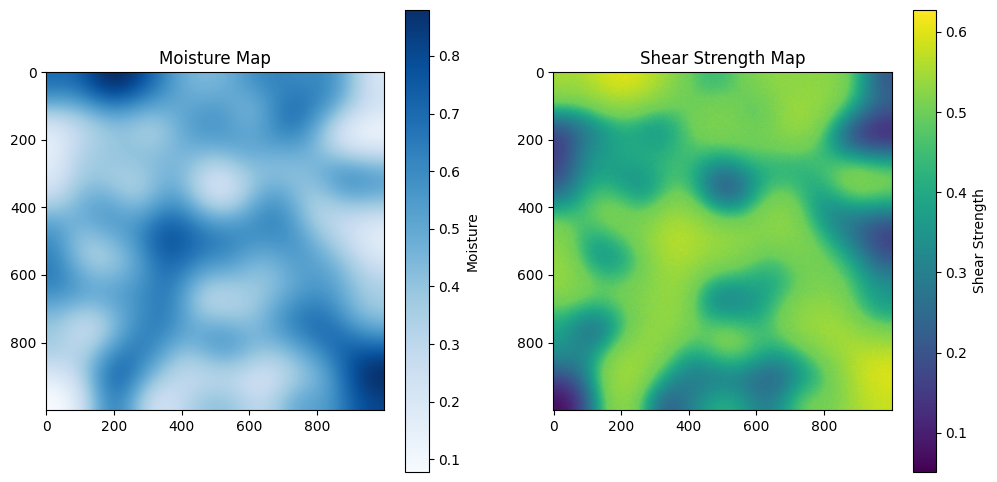

In [118]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

def generate_moisture_map(size=1000, scale=0.05, smoothness=50):
    # Generate random Gaussian noise
    noise_matrix = np.random.normal(loc=0.5, scale=0.15, size=(size, size))

    # Normalize and clip the noise
    noise_matrix = np.clip(noise_matrix, 0, 1)

    # Apply Gaussian filter for initial smoothing
    initial_smooth_matrix = gaussian_filter(noise_matrix, sigma=scale * size)

    # Normalize again after initial smoothing
    initial_smooth_matrix = (initial_smooth_matrix - np.min(initial_smooth_matrix)) / (np.max(initial_smooth_matrix) - np.min(initial_smooth_matrix))

    # Apply a second, larger Gaussian filter for creating large smooth areas
    moisture_map = gaussian_filter(initial_smooth_matrix, sigma=smoothness)

    return moisture_map

def calculate_shear_strength(moisture_map):
    # Calculate shear strength based on moisture
    shear_strength_map = np.where(moisture_map < 0.5, moisture_map, 0.25 * moisture_map + 0.375)

    # Add random Gaussian noise to shear strength
    noise_strength = np.random.normal(loc=0, scale=0.01, size=moisture_map.shape)
    shear_strength_map += noise_strength

    # Clip the values to maintain them within a reasonable range
    shear_strength_map = np.clip(shear_strength_map, 0, 1)

    return shear_strength_map

# Generate the moisture map
moisture_map = generate_moisture_map(size=1000)

# Calculate shear strength from moisture
shear_strength_map = calculate_shear_strength(moisture_map)
np.savetxt('shear_strength_map.csv', shear_strength_map, delimiter=',')
np.savetxt('moisture_map.csv', shear_strength_map, delimiter=',')
# Display the maps
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
moisture_image = ax[0].imshow(moisture_map, cmap='Blues')
ax[0].set_title('Moisture Map')
plt.colorbar(moisture_image, ax=ax[0], label='Moisture')

shear_strength_image = ax[1].imshow(shear_strength_map, cmap='viridis')
ax[1].set_title('Shear Strength Map')
plt.colorbar(shear_strength_image, ax=ax[1], label='Shear Strength')
plt.show()



In [1]:
def get_matrix_value(matrix, x, y):
    # Convert normalized coordinates to matrix indices
    ix = np.int32(x * (matrix.shape[0] - 1))
    iy =  np.int32(y * (matrix.shape[1] - 1))
    
    # Access and return the value at the specified index
    return matrix[ix, iy]

#### Use gaussian process to smooth the data or lower the density


In [31]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
# Configure warnings to always be triggered
warnings.simplefilter("always")

def Gaussian_Estimation(x, y, prediction_range,  optimizer, noise_level, length_scale, sigma_f):

    # Define the kernel
    noise_level = noise_level
    length_scale = length_scale
    sigma_f = sigma_f * sigma_f
    # kernel = C(sigma_f) * RBF(length_scale,(0.1, 0.3)) 
    kernel = C(sigma_f, (1e-3, 1e3)) * RBF(length_scale, (1e-2, 1e2)) + WhiteKernel(noise_level, (0, 0.2))

    # Instantiate the Gaussian Process Regressor
    if(not optimizer):
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, random_state=0, optimizer=None)
    else:
        gp = GaussianProcessRegressor(kernel=kernel)
    # x = np.array([x])
    # x = x.T
    # Fit the model to the data
    gp.fit(x, y)

    # Make predictions on new data points
    X_new = prediction_range
    
    y_pred, y_std = gp.predict(X_new, return_std=True)
    
    #calculate discrepancy
    
    information = np.exp(-np.square(y_std))
    # noise_level_optimized = gp.kernel_.get_params()["k2__noise_level"]
   
    return y_pred, information, y_std, #noise_level_optimized

In [5]:
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
# Read the CSV file back into a NumPy array
shear_strength_map = np.loadtxt('shear_strength_map.csv', delimiter=',')
moisture_map = np.loadtxt('moisture_map.csv', delimiter=',')

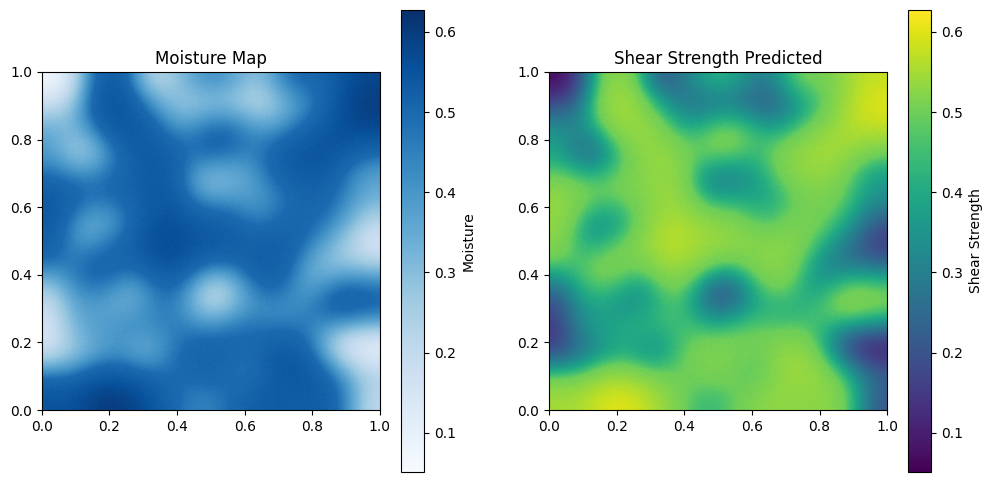

In [9]:
# choose a random path
# we assume x, y coordinates are limited to [0,1], [0,1]
# we are going to use gaussian process to estimate the data given the current robot path
# assume the robot start at coordinates [0, 1]
# assume the robot have a certain sampling density 
# the current dataset interval is 0.001, so the robot sampling interval should be larger than 0.001
# in real sceanrio, it can be an analog value
import numpy as np
import matplotlib.pyplot as plt

# ROBOT_SAMPLING_INTERVAL = 0.02        # this corresponds to the different gaits, e.g. walking/troting/running
# ROBOT_ESTIMATION_INTERVAL = 0.05       # this corresonding the density of gaussian estimation.
# ROBOT_SPEED = 1 
# ROBOT_START_POINT = [0,0]
# STEPS = 20  # Number of simulation steps



# robot_path_x = np.array([ROBOT_START_POINT[0]])
# robot_path_y = np.array([ROBOT_START_POINT[1]])
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# # calculate information and discrepancy
# measured_shear = get_matrix_value(shear_strength_map, robot_path_x, robot_path_y)
# measured_moisture = get_matrix_value(moisture_map, robot_path_x, robot_path_y)

# # create x, y robot path dependent variable 
# robot_measured_points = np.array([robot_path_x, robot_path_y]).T


# # create estimated denstiy
# estimatedNum = int(1/ROBOT_ESTIMATION_INTERVAL)
# xx1, xx2 = np.linspace(0, 1, num=estimatedNum), np.linspace(0, 1, num=estimatedNum)
# vals = np.array([[x1_, x2_] for x1_ in xx1 for x2_ in xx2])
# xv, yv = np.meshgrid(xx1, xx2)

# shear_prediction, information_shear, shear_std = Gaussian_Estimation(robot_measured_points,  measured_shear,   vals, True, 0.2, 0.15, 4)
# shear_prediction = shear_prediction.reshape(estimatedNum, estimatedNum)
# information_shear = information_shear.reshape(estimatedNum, estimatedNum)
# shear_std = shear_std.reshape(estimatedNum, estimatedNum)

Information_image = ax[0].imshow(moisture_map, cmap='Blues', extent=[0, 1, 0, 1], origin='lower')
ax[0].set_title('Moisture Map')
cb_info = fig.colorbar(Information_image, ax=ax[0], label='Moisture')

shear_strength_image = ax[1].imshow(shear_strength_map, cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
ax[1].set_title('Shear Strength Predicted')
cb_strength = fig.colorbar(shear_strength_image, ax=ax[1], label='Shear Strength')

plt.show()


    



In [ ]:
def update(frame):
    global robot_path_x, robot_path_y
    # calculate information and discrepancy
    measured_shear = get_matrix_value(shear_strength_map, robot_path_x, robot_path_y)
    measured_moisture = get_matrix_value(moisture_map, robot_path_x, robot_path_y)

    # create x, y robot path dependent variable 
    robot_measured_points = np.array([robot_path_x, robot_path_y]).T


    # create estimated denstiy
    estimatedNum = int(1/ROBOT_ESTIMATION_INTERVAL)
    xx1, xx2 = np.linspace(0, 1, num=estimatedNum), np.linspace(0, 1, num=estimatedNum)
    vals = np.array([[x1_, x2_] for x1_ in xx1 for x2_ in xx2])
    xv, yv = np.meshgrid(xx1, xx2)

    shear_prediction, information_shear, shear_std = Gaussian_Estimation(robot_measured_points,  measured_shear,   vals, True, 0.2, 0.15, 4)
    shear_prediction = shear_prediction.reshape(estimatedNum, estimatedNum)
    information_shear = information_shear.reshape(estimatedNum, estimatedNum)
    shear_std = shear_std.reshape(estimatedNum, estimatedNum)

    ## now generate field vector to guide with the path selection. 
    F_x = -np.gradient(information_shear, axis=1)
    F_y = -np.gradient(information_shear, axis=0)

    # Determine the direction of the highest gradient
    current_x, current_y = robot_path_x[-1], robot_path_y[-1]
    idx_x = int(current_x * estimatedNum)
    idx_y = int(current_y * estimatedNum)
    gradient_norm = np.linalg.norm([F_x[idx_x, idx_y], F_y[idx_x, idx_y]])    
    step_x = ROBOT_SAMPLING_INTERVAL * F_x[idx_x, idx_y] / gradient_norm
    step_y = ROBOT_SAMPLING_INTERVAL * F_y[idx_x, idx_y] / gradient_norm
    # Update the robot's position
    next_x = np.clip(current_x + step_x, 0, 1)
    next_y = np.clip(current_y + step_y, 0, 1)
    robot_path_x = np.append(robot_path_x, next_x)
    robot_path_y = np.append(robot_path_y, next_y)
    # Clear previous content in axes
    ax[0].cla()
    ax[1].cla()
    pathplot = ax[0].streamplot(xv, yv, F_x, F_y, color='r', start_points=[[current_x, current_y]], integration_direction='forward', linewidth=0.5, density=5, maxlength=0.5)
    # Quiver plot for the potential field vectors
    fieldplot = ax[0].quiver(xv, yv, F_x, F_y, alpha=1, scale=0.15, scale_units='inches')

    # Streamplot for the path
    
        
    realpath = ax[0].plot(robot_path_x, robot_path_y, '-', color='k')


    Information_image = ax[0].imshow(shear_std, cmap='Blues',extent=[0, 1, 0, 1], origin='lower', vmin = 0, vmax = 0.3)
    ax[0].set_title('Uncertainty Map')
    
    shear_strength_image = ax[1].imshow(shear_prediction, cmap='viridis', extent=[0, 1, 1, 0], origin='lower', vmin = 0, vmax = 0.5)
    ax[1].set_title('Shear Strength Predicted')
    
    return fieldplot, pathplot, realpath, Information_image, shear_strength_image
# Create animation
ani = FuncAnimation(fig, update, frames=STEPS, blit=False)
plt.show()
# Save to video file
FFMpegWriter = animation.writers['ffmpeg']
writer = FFMpegWriter(fps=15)
ani.save('robot_path_simulation.mp4', writer=writer)


In [35]:
def init():
    """
    This init function defines the initial plot parameter
    """
    # Set initial parameter for the plot
    ax.set_xlim(0, 100)
    ax.set_ylim(-2.5, 2.5)
    return line,

def animate(frame):
    """
    This function will be called periodically by FuncAnimation. Frame parameter will be passed on each call as a counter. 
    """
    # Append data to x and y data list
    x.append(frame)
    y.append(sim_data_node_sin.get_value())
    
    # Adjust limit when step count exceeds certain number (100 in this case)
    limit = max(100, max(x))
    ax.set_xlim(limit-100, limit)
    
    # Set data for line plot
    line.set_data(x, y)
    return line,

# Create FuncAnimation object and plt.show() to show the updated animation
ani = FuncAnimation(fig, animate, frames = np.linspace(1,1000,1000), interval = 1000, init_func = init)
plt.show()

In [ ]:
# choose a random path
# we assume x, y coordinates are limited to [0,1], [0,1]
# we are going to use gaussian process to estimate the data given the current robot path
# assume the robot start at coordinates [0, 1]
# assume the robot have a certain sampling density 
# the current dataset interval is 0.001, so the robot sampling interval should be larger than 0.001
# in real sceanrio, it can be an analog value


ROBOT_SAMPLING_INTERVAL = 0.001        # this corresponds to the different gaits, e.g. walking/troting/running
ROBOT_ESTIMATION_INTERVAL = 0.01       # this corresonding the density of gaussian estimation. 
ROBOT_START_POINT = [0,0]




robot_path_x = np.array([ROBOT_START_POINT[0]])
robot_path_y = np.array([ROBOT_START_POINT[1]])

# calculate information and discrepancy
measured_shear = get_matrix_value(shear_strength_map, robot_path_x, robot_path_y)
measured_moisture = get_matrix_value(moisture_map, robot_path_x, robot_path_y)

# create x, y robot path dependent variable 
robot_measured_points = np.array([robot_path_x, robot_path_y]).T


# create estimated denstiy
estimatedNum = int(1/ROBOT_ESTIMATION_INTERVAL)
xx1, xx2 = np.linspace(0, 1, num=estimatedNum), np.linspace(0, 1, num=estimatedNum)
vals = np.array([[x1_, x2_] for x1_ in xx1 for x2_ in xx2])
xv, yv = np.meshgrid(xx1, xx2)

shear_prediction, information_shear, shear_std = Gaussian_Estimation(robot_measured_points,  measured_shear,   vals, True, 0.2, 0.15, 4)
shear_prediction.reshape(estimatedNum, estimatedNum)
information_shear.reshape(estimatedNum, estimatedNum)
shear_std.reshape(estimatedNum, estimatedNum)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
moisture_image = ax[0].imshow(information_shear, cmap='Blues')
ax[0].set_title('Moisture Map')
plt.colorbar(moisture_image, ax=ax[0], label='Moisture')

shear_strength_image = ax[1].imshow(shear_prediction, cmap='viridis')
ax[1].set_title('Shear Strength Map')
plt.colorbar(shear_strength_image, ax=ax[1], label='Shear Strength')
plt.show()


ssssssssssssss


c:\Users\shipengl\.conda\envs\humanbelief\lib\site-packages\sklearn\gaussian_process\kernels.py:339: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


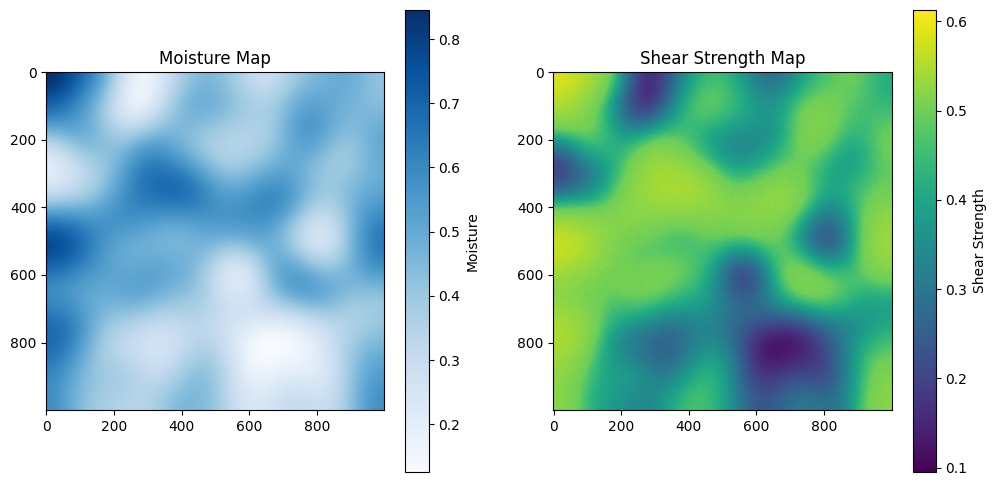

In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

def generate_moisture_map(size=1000, scale=0.05, smoothness=50):
    # Generate random Gaussian noise
    noise_matrix = np.random.normal(loc=0.5, scale=0.15, size=(size, size))

    # Normalize and clip the noise
    noise_matrix = np.clip(noise_matrix, 0, 1)

    # Apply Gaussian filter for initial smoothing
    initial_smooth_matrix = gaussian_filter(noise_matrix, sigma=scale * size)

    # Normalize again after initial smoothing
    initial_smooth_matrix = (initial_smooth_matrix - np.min(initial_smooth_matrix)) / (np.max(initial_smooth_matrix) - np.min(initial_smooth_matrix))

    # Apply a second, larger Gaussian filter for creating large smooth areas
    moisture_map = gaussian_filter(initial_smooth_matrix, sigma=smoothness)

    return moisture_map

def calculate_shear_strength(moisture_map):
    # Calculate shear strength based on moisture
    shear_strength_map = np.where(moisture_map < 0.5, moisture_map, 0.25 * moisture_map + 0.375)

    # Add random Gaussian noise to shear strength
    noise_strength = np.random.normal(loc=0, scale=0.01, size=moisture_map.shape)
    shear_strength_map += noise_strength

    # Clip the values to maintain them within a reasonable range
    shear_strength_map = np.clip(shear_strength_map, 0, 1)

    return shear_strength_map

# Generate the moisture map
moisture_map = generate_moisture_map()

# Calculate shear strength from moisture
shear_strength_map = calculate_shear_strength(moisture_map)

# Display the maps
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
moisture_image = ax[0].imshow(moisture_map, cmap='Blues')
ax[0].set_title('Moisture Map')
plt.colorbar(moisture_image, ax=ax[0], label='Moisture')

shear_strength_image = ax[1].imshow(shear_strength_map, cmap='viridis')
ax[1].set_title('Shear Strength Map')
plt.colorbar(shear_strength_image, ax=ax[1], label='Shear Strength')
plt.show()



### generate convel hull

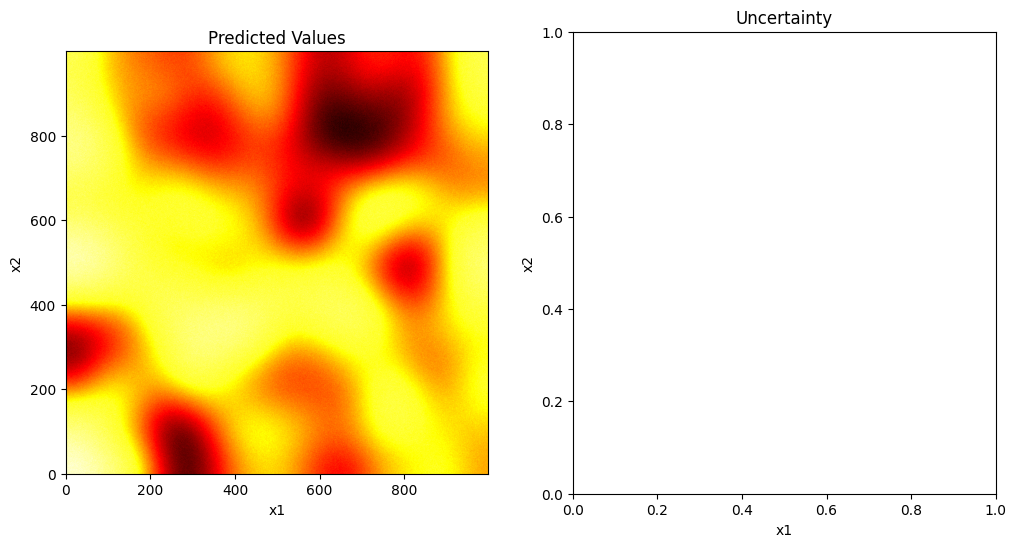

In [ ]:
risk_matrix = (shear_strength_map)
# Function to identify high risk points from the risk matrix
def extract_high_risk_points(risk_matrix, risk_level=0.4):
    high_risk_points = np.argwhere(risk_matrix > risk_level)
    return high_risk_points

# Function to create convex hulls from points
def create_convex_hulls(points):
    hulls = []
    if len(points) > 2:  # Need at least 3 points to create a convex hull
        hull = ConvexHull(points)
        hulls.append(points[hull.vertices])
    return hulls


from sklearn.cluster import DBSCAN
# Function to perform the clustering and convex hull creation
def cluster_and_create_hulls(risk_matrix, eps=1, min_samples=5, risk_level=0.5):
    high_risk_points = extract_high_risk_points(risk_matrix, risk_level)
    if len(high_risk_points) == 0:
        return []
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(high_risk_points)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    

    # Create convex hull for each cluster
    hulls = []
    for k in unique_labels:
        # Ignore noise points, which are labeled as -1
        if k == -1:
            continue
        class_member_mask = (labels == k)
        cluster_points = high_risk_points[class_member_mask]
        hulls.append(cluster_points)

    return hulls
def normalize_matrix(matrix):
        """
        Normalize a numpy matrix so that the minimum value is mapped to 0 and the maximum value is mapped to 1.

        Parameters:
        matrix (np.array): A numpy array of any shape.

        Returns:
        np.array: A normalized numpy array of the same shape as the input.
        """
        # Find the minimum and maximum values in the matrix
        min_val = np.min(matrix)
        max_val = np.max(matrix)
        
        # Perform the normalization
        normalized_matrix = (matrix - min_val) / (max_val - min_val)

        return normalized_matrix
from sklearn.cluster import DBSCAN
# Function to perform the clustering and convex hull creation
def cluster_and_create_hulls(risk_matrix, eps=5, min_samples=20, risk_level=0.6):
    high_risk_points = extract_high_risk_points(risk_matrix, risk_level)
    if len(high_risk_points) == 0:
        return []
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(high_risk_points)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    

    # Create convex hull for each cluster
    hulls = []
    for k in unique_labels:
        # Ignore noise points, which are labeled as -1
        if k == -1:
            continue
        class_member_mask = (labels == k)
        cluster_points = high_risk_points[class_member_mask]
        hulls.append(cluster_points)

    return hulls

# Now let's do the actual clustering and create convex hulls for our dummy risk matrix
hulls = cluster_and_create_hulls(risk_matrix)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

cax = ax[0].imshow(risk_matrix, cmap='hot', origin='lower')
for hull in hulls:
    ax[0].fill(hull[:, 1], hull[:, 0], edgecolor='k', fill=False, alpha=0.5)
ax[0].set_title("Risk Areas Enclosed by Convex Hulls")
# y_std = normalize_matrix(y_std)
# hulls = cluster_and_create_hulls(y_std)
# cax = ax[1].imshow(y_std, cmap='hot', origin='lower')
# for hull in hulls:
#     ax[1].fill(hull[:, 1], hull[:, 0], edgecolor='k', fill=False, alpha=0.5)
# ax[1].set_title("Risk Areas Enclosed by Convex Hulls")
# cax = ax[0].imshow(y_pred, cmap='coolwarm')
ax[0].set_title('Predicted Values')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
# cax2 = ax[1].imshow(y_std, cmap='coolwarm')
ax[1].set_title('Uncertainty')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
plt.show()

    

KeyboardInterrupt: 

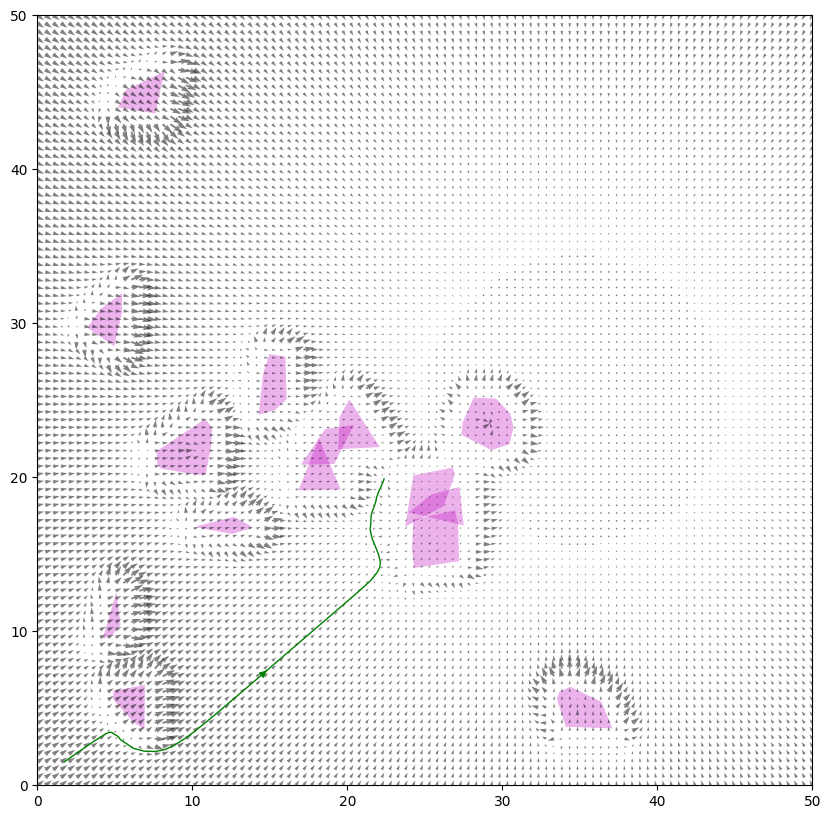

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
import random

# Constants and setup
k_attr = 10.0  # Attractive potential constant
k_rep = 1000.0  # Repulsive potential constant
rho_0 = 10.0  # Decreased influence range
x_min, x_max, y_min, y_max = 0, 50, 0, 50
x_start, y_start = 1, 1  # Start position
goals = [(35, 25), (10, 40), (40, 10)]  # Goals with priorities

# Create a grid of points
x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Generate convex hulls as obstacles
hulls = []
for _ in range(15):
    center_x, center_y = np.random.uniform(x_min + 5, x_max - 5, 2)
    points = np.random.rand(random.randint(5, 10), 2) * 4 + np.array([center_x, center_y]) - 2
    hull = ConvexHull(points)
    hulls.append(points[hull.vertices])

def distance_to_edge(point, hull):
    min_distance = np.inf
    for i in range(len(hull)):
        p1, p2 = hull[i], hull[(i + 1) % len(hull)]
        edge_vec = p2 - p1
        point_vec = point - p1
        proj = np.clip(np.dot(point_vec, edge_vec) / np.dot(edge_vec, edge_vec), 0, 1)
        closest = p1 + proj * edge_vec
        distance = np.linalg.norm(closest - point)
        min_distance = min(min_distance, distance)
    return min_distance

def calculate_potentials_and_gradients(x_goal, y_goal):
    # Attractive potential
    U_attr = k_attr * ((x - x_goal)**2 + (y - y_goal)**2)
    # Repulsive potential
    U_rep = np.zeros_like(x)
    for hull in hulls:
        for i in range(len(x)):
            for j in range(len(y)):
                rho = distance_to_edge([x[i, j], y[i, j]], hull)
                if rho < rho_0:
                    U_rep[i, j] += k_rep * ((1.0 / rho - 1.0 / rho_0)**2)
    U_rep = np.clip(U_rep, a_min=None, a_max=k_rep)
    U_total = U_attr + U_rep
    F_x = -np.gradient(U_total, axis=1)
    F_y = -np.gradient(U_total, axis=0)
    return F_x, F_y

# Plotting setup
colors = ['green', 'blue', 'cyan']  # Different colors for different paths
plt.figure(figsize=(10, 10))

# Plot convex hulls as obstacles
for hull in hulls:
    plt.fill(hull[:, 0], hull[:, 1], 'm', alpha=0.3)

current_position = [x_start, y_start]
for index, goal in enumerate(goals):
    x_goal, y_goal = goal
    F_x, F_y = calculate_potentials_and_gradients(x_goal, y_goal)
    
    # Quiver plot for the potential field vectors
    plt.quiver(x, y, F_x, F_y, alpha=0.5)
    
    # Streamplot for the path
    plt.streamplot(x, y, F_x, F_y, color=colors[index % len(colors)], start_points=[current_position], integration_direction='forward', linewidth=1, density=2)
    
    current_position = [x_goal, y_goal]

# Plot goals and start
plt.plot(x_start, y_start, 'ro', markersize=10, label='Start')
for index, (x_goal, y_goal) in enumerate(goals):
    plt.plot(x_goal, y_goal, 'go', markersize=12)

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Robot Path with Potential Fields, Multiple Goals, and Convex Hull Obstacles')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()
